In [1]:
!pip install --user annoy

  Created wheel for annoy: filename=annoy-1.17.2-cp38-cp38-win_amd64.whl size=53331 sha256=c86291353c78a5333c8e7d850a1752956fb4651b63893af36227f5a90f80c188
  Stored in directory: c:\users\tim\appdata\local\pip\cache\wheels\57\d0\68\b78ab3f9c186d63aaeb98556efc99c0802b3227698b8de2614
Successfully built annoy


In [95]:
import pandas as pd
import numpy as np

%env JOBLIB_TEMP_FOLDER=/tmp
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.cluster import DBSCAN, AffinityPropagation, SpectralClustering, KMeans

import nltk
from nltk.corpus import stopwords as nltk_stopwords

import pickle
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from pymystem3 import Mystem
from tqdm import tqdm_notebook as tqdm

env: JOBLIB_TEMP_FOLDER=/tmp


In [4]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Tim\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

In [48]:
data = pd.read_csv('recsys/data/repositories_cleaned.csv')

data = data[~data['description_cleaned'].isna()]

descs = data['description_cleaned'].values.astype('U')

In [12]:
tf_idf = count_tf_idf.fit_transform(corpus)

In [13]:
print("Размер матрицы:", tf_idf.shape)

Размер матрицы: (35238, 20414)


In [15]:
data.shape[0]

35238

In [17]:
tf_idf.shape[0]

35238

In [27]:
import matplotlib.pyplot as plt

(array([   16.,    43.,   103.,   225.,   360.,   580.,   933.,  1473.,
         2572., 14109.]),
 array([ 3.79948018,  4.49720831,  5.19493645,  5.89266458,  6.59039272,
         7.28812085,  7.98584899,  8.68357712,  9.38130525, 10.07903339,
        10.77676152]),
 <BarContainer object of 10 artists>)

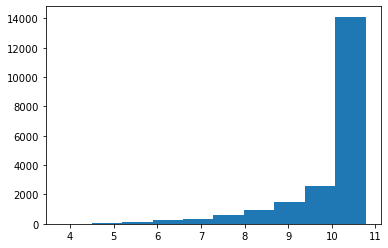

In [30]:
idfs = count_tf_idf.idf_
plt.hist(idfs)

In [34]:
lower_thresh = 3.
upper_thresh = 10.
not_often = idfs > lower_thresh
not_rare = idfs < upper_thresh

mask = not_often * not_rare

good_words = np.array(count_tf_idf.get_feature_names())[mask]

In [42]:
good_words = good_words.tolist()

In [44]:
voc_len

6305

In [43]:
m = Mystem()
stemmed = set()
voc_len = len(good_words)
for i in tqdm(range(voc_len)):
    word = good_words.pop()
    stemmed_word = m.lemmatize(word)[0]
    stemmed.add(stemmed_word)

stemmed = list(stemmed)
print('After stemming: %d'%(len(stemmed)))

<ipython-input-43-18630cc11825>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(voc_len)):


  0%|          | 0/6305 [00:00<?, ?it/s]

After stemming: 6305


In [47]:
corpus

array(['javascript d library ',
       ' web framework for building viual reality experiences ',
       'a brief computer graphics rendering course', ...,
       'repository of public domain and freely licensed bibles in some standard xml formats ',
       'fedramp automation',
       'a modern css selector implementation for beautifulsoup'],
      dtype='<U20292')

In [51]:
len(descs)

35238

In [52]:
voc = {word : i for i,word in enumerate(stemmed)}

count_vect = CountVectorizer(stop_words=stopwords,
                             vocabulary=voc)

dataset = count_vect.fit_transform(descs) 

In [56]:
lda = LDA(n_components = 60, max_iter=30, n_jobs=6, learning_method='batch', verbose=1)
lda.fit(dataset)

iteration: 1 of max_iter: 30
iteration: 2 of max_iter: 30
iteration: 3 of max_iter: 30
iteration: 4 of max_iter: 30
iteration: 5 of max_iter: 30
iteration: 6 of max_iter: 30
iteration: 7 of max_iter: 30
iteration: 8 of max_iter: 30
iteration: 9 of max_iter: 30
iteration: 10 of max_iter: 30
iteration: 11 of max_iter: 30
iteration: 12 of max_iter: 30
iteration: 13 of max_iter: 30
iteration: 14 of max_iter: 30
iteration: 15 of max_iter: 30
iteration: 16 of max_iter: 30
iteration: 17 of max_iter: 30
iteration: 18 of max_iter: 30
iteration: 19 of max_iter: 30
iteration: 20 of max_iter: 30
iteration: 21 of max_iter: 30
iteration: 22 of max_iter: 30
iteration: 23 of max_iter: 30
iteration: 24 of max_iter: 30
iteration: 25 of max_iter: 30
iteration: 26 of max_iter: 30
iteration: 27 of max_iter: 30
iteration: 28 of max_iter: 30
iteration: 29 of max_iter: 30
iteration: 30 of max_iter: 30


LatentDirichletAllocation(max_iter=30, n_components=60, n_jobs=6, verbose=1)

In [62]:
joblib.dump(lda, 'models/lda.pkl')
joblib.dump(count_vect, 'models/countVect.pkl')
joblib.dump(count_tf_idf,'models/tf_idf.pkl')

['models/tf_idf.pkl']

In [53]:
dataset

<35238x6305 sparse matrix of type '<class 'numpy.int64'>'
	with 241038 stored elements in Compressed Sparse Row format>

In [63]:
class TopicModeler(object):
    '''
    Inteface object for CountVectorizer + LDA simple
    usage.
    '''
    def __init__(self, count_vect, lda):
        '''
        Args:
             count_vect - CountVectorizer object from sklearn.
             lda - LDA object from sklearn.
        '''
        self.lda = lda
        self.count_vect = count_vect
        self.count_vect.input = 'content'
        
    def __call__(self, text):
        '''
        Gives topics distribution for a given text
        Args:
             text - raw text via python string.
        returns: numpy array - topics distribution for a given text.
        '''
        vectorized = self.count_vect.transform([text])
        lda_topics = self.lda.transform(vectorized)
        return lda_topics
    def get_keywords(self, text, n_topics=3, n_keywords=5):
        '''
        For a given text gives n top keywords for each of m top texts topics.
        Args:
             text - raw text via python string.
             n_topics - int how many top topics to use.
             n_keywords - how many top words of each topic to return.
        returns:
                list - of m*n keywords for a given text.
        '''
        lda_topics = self(text)
        lda_topics = np.squeeze(lda_topics, axis=0)
        n_topics_indices = lda_topics.argsort()[-n_topics:][::-1]
        
        top_topics_words_dists = []
        for i in n_topics_indices:
            top_topics_words_dists.append(self.lda.components_[i])
        
        keywords = np.zeros(shape=(n_keywords*n_topics, self.lda.components_.shape[1]))
        for i,topic in enumerate(top_topics_words_dists):
            n_keywords_indices = topic.argsort()[-n_keywords:][::-1]
            for k,j in enumerate(n_keywords_indices):
                keywords[i * n_keywords + k, j] = 1
        keywords = self.count_vect.inverse_transform(keywords)
        keywords = [keyword[0] for keyword in keywords]
        return keywords  

In [64]:
tm = TopicModeler(count_vect, lda)

In [ ]:
des

In [66]:
descs[4]

'this is the official source code of freecad a free and opensource multiplatform d parametric modeler issues are managed on our own bug tracker at www freecadweb org tracker'

In [118]:
key_words = tm.get_keywords(descs[4], n_topics=1, n_keywords=10)
print(key_words)

['spring', 'security', 'cloud', 'boot', 'example', 'console', 'ip', 'logging', 'java', 'three']


In [69]:
 #getting n_top words indices for every topic
sorted_words_coeffs = lda.components_.argsort(axis=1)
n_top = 10
top_coefs = sorted_words_coeffs[:,-n_top:][:,::-1]

#making those texts consisting of top words
vect_texts = np.zeros((top_coefs.shape[0], lda.components_.shape[1]),
                       )
for i,n_top_coefs in enumerate(top_coefs):
    for coef in n_top_coefs:
        vect_texts[i,coef] = 1

In [70]:
top_words = count_vect.inverse_transform(vect_texts)
top_words_set = set()
for words in top_words:
    top_words_set.update(set(words))
print(len(top_words_set))

539


In [71]:
voc_to_idf = {word : i for i, word in enumerate(top_words_set)}
tfidf_tw = TfidfVectorizer(vocabulary=voc_to_idf, stop_words=stopwords)
tfidf_tw.fit(descs)

idfs = tfidf_tw.idf_
print(idfs.shape)

(539,)


In [72]:
#computing n most common words
n_top = int(idfs.shape[0] * 0.05)

n_top_indices = np.argsort(idfs)[:n_top]

vect_words = np.zeros((n_top, len(idfs)))

In [73]:
 #adding them to list.
inv_voc_to_idf = { voc_to_idf[key] : key for key in voc_to_idf.keys()}
extra_stop_words = []
for ind in n_top_indices:
    extra_stop_words.append(inv_voc_to_idf[ind])
print(len(extra_stop_words))

26


In [74]:
print(extra_stop_words)

['library', 'web', 'framework', 'using', 'based', 'code', 'js', 'api', 'data', 'react', 'source', 'open', 'simple', 'python', 'plugin', 'app', 'tool', 'javascript', 'github', 'platform', 'android', 'server', 'node', 'learning', 'project', 'use']


In [75]:
term_doc_matrix = count_vect.transform(descs)
embeddings = lda.transform(term_doc_matrix)

In [127]:
term_doc_matrix_for_one = count_vect.transform([descs[4]])
embeddings = lda.transform(term_doc_matrix_for_one)

In [128]:
embeddings

array([[0.00104167, 0.00104167, 0.00104167, 0.00104167, 0.00104167,
        0.00104167, 0.00104167, 0.00104167, 0.00104167, 0.00104167,
        0.00104167, 0.05934964, 0.00104167, 0.00104167, 0.13023369,
        0.00104167, 0.00104167, 0.00104167, 0.00104167, 0.00104167,
        0.00104167, 0.00104167, 0.00104167, 0.00104167, 0.00104167,
        0.00104167, 0.00104167, 0.12604167, 0.19334192, 0.00104167,
        0.00104167, 0.00104167, 0.00104167, 0.00104167, 0.00104167,
        0.00104167, 0.30874142, 0.12604167, 0.00104167, 0.00104167,
        0.00104167, 0.00104167, 0.00104167, 0.00104167, 0.00104167,
        0.00104167, 0.00104167, 0.00104167, 0.00104167, 0.00104167,
        0.00104167, 0.00104167, 0.00104167, 0.00104167, 0.00104167,
        0.00104167, 0.00104167, 0.00104167, 0.00104167, 0.00104167]])

In [125]:
data

,topic,name,owner,full_name,description,language,tags,open_issues,forks,stars,watchers,description_cleaned,embeddings_lda
0,3d,three.js,mrdoob,mrdoob/three.js,JavaScript 3D Library.,JavaScript,"['javascript', 'svg', 'webgl', 'html5', 'canva...",472,31277,80797,80797,javascript d library,"[0.005555555555555608, 0.005555555555555608, 0..."
4,3d,aframe,aframevr,aframevr/aframe,🅰️ web framework for building virtual reality ...,JavaScript,"['html', 'threejs', 'game-engine', 'vr', 'webv...",360,3388,14003,14003,web framework for building viual reality expe...,"[0.0023809523809524215, 0.0023809523809524215,..."
5,3d,tinyrenderer,ssloy,ssloy/tinyrenderer,A brief computer graphics / rendering course,C++,"['learning', 'c-plus-plus', 'fun', 'tutorial',...",28,1254,13424,13424,a brief computer graphics rendering course,"[0.0027777777777780264, 0.0027777777777780264,..."
6,3d,3d-game-shaders-for-beginners,lettier,lettier/3d-game-shaders-for-beginners,"🎮 A step-by-step guide to implementing SSAO, d...",C++,"['gamedev', 'webgl', 'opengl', 'unity', 'shade...",14,957,12567,12567,a step by step guide to implementing ssao dep...,"[0.0015151515151518534, 0.0015151515151518534,..."
7,3d,FreeCAD,FreeCAD,FreeCAD/FreeCAD,"This is the official source code of FreeCAD, a...",C++,"['windows', 'linux', 'engineering', 'architect...",754,2702,11073,11073,this is the official source code of freecad a ...,"[0.0010416666666669273, 0.0010416666666669273,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
40627,xml,sepa_king,salesking,salesking/sepa_king,Ruby gem for creating SEPA XML files,Ruby,"['ruby', 'rubygems', 'xml', 'payment', 'fintec...",11,106,128,128,ruby gem for creating sepa xml files,"[0.0027777777777779926, 0.0027777777777779926,..."
40628,xml,Sitemap,ThePixelDeveloper,ThePixelDeveloper/Sitemap,PHP XML Sitemap Generation,PHP,"['php', 'sitemap', 'xml', 'xml-sitemap', 'site...",5,36,128,128,php xml sitemap generation,"[0.003333333333334223, 0.003333333333334223, 0..."
40629,xml,open-bibles,seven1m,seven1m/open-bibles,Repository of public domain and freely license...,Python,"['xml', 'bible', 'bible-api']",0,36,126,126,repository of public domain and freely license...,"[0.0018518518518527002, 0.0018518518518527002,..."
40630,xml,fedramp-automation,GSA,GSA/fedramp-automation,FedRAMP Automation,XSLT,"['json', 'automation', 'xml', 'sap', 'authoriz...",30,46,131,131,fedramp automation,"[0.008333333333333406, 0.008333333333333406, 0..."


In [77]:
len(embeddings)

35238

In [82]:
embeddings

array([[0.00555556, 0.00555556, 0.00555556, ..., 0.00555556, 0.00555556,
        0.00555556],
       [0.00238095, 0.00238095, 0.00238095, ..., 0.00238095, 0.00238095,
        0.00238095],
       [0.00277778, 0.00277778, 0.00277778, ..., 0.00277778, 0.00277778,
        0.00277778],
       ...,
       [0.00185185, 0.00185185, 0.00185185, ..., 0.00185185, 0.00185185,
        0.00185185],
       [0.00833333, 0.00833333, 0.00833333, ..., 0.00833333, 0.00833333,
        0.00833333],
       [0.00333333, 0.00333333, 0.20333333, ..., 0.00333333, 0.00333333,
        0.00333333]])

In [83]:
data['embeddings_lda'] = list(embeddings)

In [87]:
data = data.drop('Unnamed: 0', axis=1)

In [88]:
data.to_csv('recsys/data/repositories_embeddings_LDA_1.csv')

In [19]:
from sklearn.manifold import TSNE

In [90]:
kmeans = KMeans(n_clusters=30)
clust_labels = kmeans.fit_predict(embeddings)
clust_centers = kmeans.cluster_centers_

In [91]:
embeddings_to_tsne = np.concatenate((embeddings,clust_centers), axis=0)

tSNE =  TSNE(n_components=2, perplexity=15)
tsne_embeddings = tSNE.fit_transform(embeddings_to_tsne)
tsne_embeddings, centroids_embeddings = np.split(tsne_embeddings, [len(clust_labels)], axis=0)

In [93]:
print(tsne_embeddings.shape,centroids_embeddings.shape)

(35238, 2) (30, 2)


In [96]:
clust_indices = np.unique(clust_labels)

clusters = {clust_ind : [] for clust_ind in clust_indices}
for emb, label in zip(tsne_embeddings, clust_labels):
    clusters[label].append(emb)

for key in clusters.keys():
    clusters[key] = np.array(clusters[key])
colors = cm.rainbow(np.linspace(0, 1, len(clust_indices)))

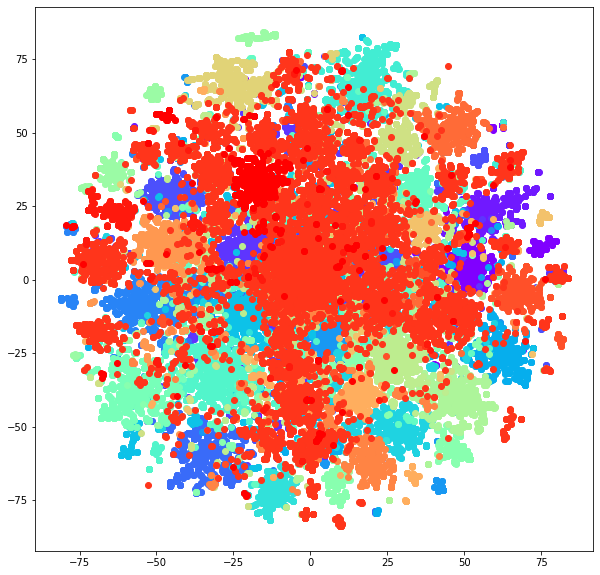

In [97]:
plt.figure(figsize=(10,10))
for ind, color in zip(clust_indices, colors):
    x = clusters[ind][:,0]
    y = clusters[ind][:,1]
    plt.scatter(x, y, color=color)
    
    centroid = centroids_embeddings[ind]
    plt.scatter(centroid[0],centroid[1], color=color, marker='x', s=100)

plt.show()

In [100]:
dim = len(data['embeddings_lda'].iloc[0])
dim

60

In [102]:
repos_ann = AnnoyIndex(dim, 'angular')  # Length of item vector that will be indexed
repos_mapping = {}
for i, (repo_id, e) in enumerate(data['embeddings_lda'].iteritems()):
    repos_ann.add_item(i, list(e))
    repos_mapping[repo_id] = i

In [103]:
n_trees = 1_000

%time repos_ann.build(n_trees)

Wall time: 28.8 s


True

In [104]:
repos_ann.save('models/repos.ann')
pd.to_pickle(repos_mapping, 'models/repos_mapping.pkl')

In [105]:
repos_ann = AnnoyIndex(dim, 'angular')
repos_ann.load('./models/repos.ann') # super fast, will just mmap the file
repos_mapping = pd.read_pickle('./models/repos_mapping.pkl')
repos_mapping_rev = {v: k for k, v in repos_mapping.items()}
len(repos_mapping)

35238

In [111]:
def get_nns_by_repo_id(repo_id, n_nn=10):
    res, dist = repos_ann.get_nns_by_item(repos_mapping[repo_id], n_nn, include_distances=True) # will find the n nearest neighbors
    res = [repos_mapping_rev[r] for r in res]
    res = data.loc[res]
    res['distance'] = [round(d, 3) for d in dist]
    return res

In [108]:
data

,topic,name,owner,full_name,description,language,tags,open_issues,forks,stars,watchers,description_cleaned,embeddings_lda
0,3d,three.js,mrdoob,mrdoob/three.js,JavaScript 3D Library.,JavaScript,"['javascript', 'svg', 'webgl', 'html5', 'canva...",472,31277,80797,80797,javascript d library,"[0.005555555555555608, 0.005555555555555608, 0..."
4,3d,aframe,aframevr,aframevr/aframe,🅰️ web framework for building virtual reality ...,JavaScript,"['html', 'threejs', 'game-engine', 'vr', 'webv...",360,3388,14003,14003,web framework for building viual reality expe...,"[0.0023809523809524215, 0.0023809523809524215,..."
5,3d,tinyrenderer,ssloy,ssloy/tinyrenderer,A brief computer graphics / rendering course,C++,"['learning', 'c-plus-plus', 'fun', 'tutorial',...",28,1254,13424,13424,a brief computer graphics rendering course,"[0.0027777777777780264, 0.0027777777777780264,..."
6,3d,3d-game-shaders-for-beginners,lettier,lettier/3d-game-shaders-for-beginners,"🎮 A step-by-step guide to implementing SSAO, d...",C++,"['gamedev', 'webgl', 'opengl', 'unity', 'shade...",14,957,12567,12567,a step by step guide to implementing ssao dep...,"[0.0015151515151518534, 0.0015151515151518534,..."
7,3d,FreeCAD,FreeCAD,FreeCAD/FreeCAD,"This is the official source code of FreeCAD, a...",C++,"['windows', 'linux', 'engineering', 'architect...",754,2702,11073,11073,this is the official source code of freecad a ...,"[0.0010416666666669273, 0.0010416666666669273,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
40627,xml,sepa_king,salesking,salesking/sepa_king,Ruby gem for creating SEPA XML files,Ruby,"['ruby', 'rubygems', 'xml', 'payment', 'fintec...",11,106,128,128,ruby gem for creating sepa xml files,"[0.0027777777777779926, 0.0027777777777779926,..."
40628,xml,Sitemap,ThePixelDeveloper,ThePixelDeveloper/Sitemap,PHP XML Sitemap Generation,PHP,"['php', 'sitemap', 'xml', 'xml-sitemap', 'site...",5,36,128,128,php xml sitemap generation,"[0.003333333333334223, 0.003333333333334223, 0..."
40629,xml,open-bibles,seven1m,seven1m/open-bibles,Repository of public domain and freely license...,Python,"['xml', 'bible', 'bible-api']",0,36,126,126,repository of public domain and freely license...,"[0.0018518518518527002, 0.0018518518518527002,..."
40630,xml,fedramp-automation,GSA,GSA/fedramp-automation,FedRAMP Automation,XSLT,"['json', 'automation', 'xml', 'sap', 'authoriz...",30,46,131,131,fedramp automation,"[0.008333333333333406, 0.008333333333333406, 0..."


In [109]:
repo_query = 'apache/spark'

data[data['full_name'].str.lower().str.contains(repo_query)]

,topic,name,owner,full_name,description,language,tags,open_issues,forks,stars,watchers,description_cleaned,embeddings_lda
19529,java,spark,apache,apache/spark,Apache Spark - A unified analytics engine for ...,Scala,"['python', 'java', 'r', 'scala', 'sql', 'big-d...",217,25454,32515,32515,apache spark a unified analytics engine for la...,"[0.0016666666666667572, 0.0016666666666667572,..."
30227,python,spark,apache,apache/spark,Apache Spark - A unified analytics engine for ...,Scala,"['python', 'java', 'r', 'scala', 'sql', 'big-d...",223,25456,32519,32519,apache spark a unified analytics engine for la...,"[0.0016666666666667572, 0.0016666666666667572,..."
30494,r,spark,apache,apache/spark,Apache Spark - A unified analytics engine for ...,Scala,"['python', 'java', 'r', 'scala', 'sql', 'big-d...",223,25456,32519,32519,apache spark a unified analytics engine for la...,"[0.0016666666666667572, 0.0016666666666667572,..."
32791,scala,spark,apache,apache/spark,Apache Spark - A unified analytics engine for ...,Scala,"['python', 'java', 'r', 'scala', 'sql', 'big-d...",223,25455,32520,32520,apache spark a unified analytics engine for la...,"[0.0016666666666667572, 0.0016666666666667572,..."
34861,sql,spark,apache,apache/spark,Apache Spark - A unified analytics engine for ...,Scala,"['python', 'java', 'r', 'scala', 'sql', 'big-d...",223,25455,32520,32520,apache spark a unified analytics engine for la...,"[0.0016666666666667572, 0.0016666666666667572,..."


In [113]:
data

,topic,name,owner,full_name,description,language,tags,open_issues,forks,stars,watchers,description_cleaned,embeddings_lda
0,3d,three.js,mrdoob,mrdoob/three.js,JavaScript 3D Library.,JavaScript,"['javascript', 'svg', 'webgl', 'html5', 'canva...",472,31277,80797,80797,javascript d library,"[0.005555555555555608, 0.005555555555555608, 0..."
4,3d,aframe,aframevr,aframevr/aframe,🅰️ web framework for building virtual reality ...,JavaScript,"['html', 'threejs', 'game-engine', 'vr', 'webv...",360,3388,14003,14003,web framework for building viual reality expe...,"[0.0023809523809524215, 0.0023809523809524215,..."
5,3d,tinyrenderer,ssloy,ssloy/tinyrenderer,A brief computer graphics / rendering course,C++,"['learning', 'c-plus-plus', 'fun', 'tutorial',...",28,1254,13424,13424,a brief computer graphics rendering course,"[0.0027777777777780264, 0.0027777777777780264,..."
6,3d,3d-game-shaders-for-beginners,lettier,lettier/3d-game-shaders-for-beginners,"🎮 A step-by-step guide to implementing SSAO, d...",C++,"['gamedev', 'webgl', 'opengl', 'unity', 'shade...",14,957,12567,12567,a step by step guide to implementing ssao dep...,"[0.0015151515151518534, 0.0015151515151518534,..."
7,3d,FreeCAD,FreeCAD,FreeCAD/FreeCAD,"This is the official source code of FreeCAD, a...",C++,"['windows', 'linux', 'engineering', 'architect...",754,2702,11073,11073,this is the official source code of freecad a ...,"[0.0010416666666669273, 0.0010416666666669273,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
40627,xml,sepa_king,salesking,salesking/sepa_king,Ruby gem for creating SEPA XML files,Ruby,"['ruby', 'rubygems', 'xml', 'payment', 'fintec...",11,106,128,128,ruby gem for creating sepa xml files,"[0.0027777777777779926, 0.0027777777777779926,..."
40628,xml,Sitemap,ThePixelDeveloper,ThePixelDeveloper/Sitemap,PHP XML Sitemap Generation,PHP,"['php', 'sitemap', 'xml', 'xml-sitemap', 'site...",5,36,128,128,php xml sitemap generation,"[0.003333333333334223, 0.003333333333334223, 0..."
40629,xml,open-bibles,seven1m,seven1m/open-bibles,Repository of public domain and freely license...,Python,"['xml', 'bible', 'bible-api']",0,36,126,126,repository of public domain and freely license...,"[0.0018518518518527002, 0.0018518518518527002,..."
40630,xml,fedramp-automation,GSA,GSA/fedramp-automation,FedRAMP Automation,XSLT,"['json', 'automation', 'xml', 'sap', 'authoriz...",30,46,131,131,fedramp automation,"[0.008333333333333406, 0.008333333333333406, 0..."


In [112]:
repo_id = 19529

get_nns_by_repo_id(repo_id)

,topic,name,owner,full_name,description,language,tags,open_issues,forks,stars,watchers,description_cleaned,embeddings_lda,distance
19529,java,spark,apache,apache/spark,Apache Spark - A unified analytics engine for ...,Scala,"['python', 'java', 'r', 'scala', 'sql', 'big-d...",217,25454,32515,32515,apache spark a unified analytics engine for la...,"[0.0016666666666667572, 0.0016666666666667572,...",0.000
30227,python,spark,apache,apache/spark,Apache Spark - A unified analytics engine for ...,Scala,"['python', 'java', 'r', 'scala', 'sql', 'big-d...",223,25456,32519,32519,apache spark a unified analytics engine for la...,"[0.0016666666666667572, 0.0016666666666667572,...",0.000
30494,r,spark,apache,apache/spark,Apache Spark - A unified analytics engine for ...,Scala,"['python', 'java', 'r', 'scala', 'sql', 'big-d...",223,25456,32519,32519,apache spark a unified analytics engine for la...,"[0.0016666666666667572, 0.0016666666666667572,...",0.000
32791,scala,spark,apache,apache/spark,Apache Spark - A unified analytics engine for ...,Scala,"['python', 'java', 'r', 'scala', 'sql', 'big-d...",223,25455,32520,32520,apache spark a unified analytics engine for la...,"[0.0016666666666667572, 0.0016666666666667572,...",0.000
34861,sql,spark,apache,apache/spark,Apache Spark - A unified analytics engine for ...,Scala,"['python', 'java', 'r', 'scala', 'sql', 'big-d...",223,25455,32520,32520,apache spark a unified analytics engine for la...,"[0.0016666666666667572, 0.0016666666666667572,...",0.000
15766,game-engine,Unity2D-Components,cmilr,cmilr/Unity2D-Components,A constantly evolving array of Unity C# compon...,C#,"['c-sharp', 'gamedev', 'csharp', 'game-engine'...",0,65,447,447,a constantly evolving array of unity c# compon...,"[0.0007936507936510763, 0.0007936507936510763,...",0.330
29286,pixel-art,Unity2D-Components,cmilr,cmilr/Unity2D-Components,A constantly evolving array of Unity C# compon...,C#,"['c-sharp', 'gamedev', 'csharp', 'game-engine'...",0,65,447,447,a constantly evolving array of unity c# compon...,"[0.0007936507936510763, 0.0007936507936510763,...",0.330
6737,code-review,How-NOT-to-Review-a-Pull-Request,ausmith,ausmith/How-NOT-to-Review-a-Pull-Request,A presentation by Aaron Goldsmith,Shell,"['communication', 'code-review', 'pull-requests']",5,1,9,9,a presentation by aaron goldsmith,"[0.00833333333333365, 0.00833333333333365, 0.0...",0.366
12509,ember,ember-yeti-table,miguelcobain,miguelcobain/ember-yeti-table,Yeti Table,JavaScript,"['ember', 'datagrid', 'tables', 'yeti']",37,14,54,54,yeti table,"[0.008333333333333847, 0.008333333333333847, 0...",0.366
18137,haskell,foundation,haskell-foundation,haskell-foundation/foundation,Empire strikes back,Haskell,"['haskell', 'foundation', 'prelude']",124,78,458,458,empire strikes back,"[0.008333333333333455, 0.008333333333336763, 0...",0.366


In [ ]:
for i, (repo_id, e) in enumerate(tf_idf)):
    repos_ann.add_item(i, list(e))
    repos_mapping[repo_id] = i

In [2]:
from annoy import AnnoyIndex
import random

f = 2  # Length of item vector that will be indexed

t = AnnoyIndex(f, 'angular')
for i in range(tf_idf.shape[0]):
    v = [random.gauss(0, 1) for z in range(tf_idf.shape[0])]
    t.add_item(i, v)

t.build(10) # 10 trees
t.save('test.ann')

# ...

u = AnnoyIndex(f, 'angular')
u.load('test.ann') # super fast, will just mmap the file
print(u.get_nns_by_item(0, 1000)) # will find the 1000 nearest neighbors

[0, 275, 656, 537, 209, 456, 130, 101, 998, 13, 866, 737, 147, 660, 251, 31, 907, 651, 525, 745, 739, 825, 95, 782, 711, 78, 518, 235, 490, 440, 929, 477, 568, 994, 850, 131, 172, 903, 556, 538, 676, 926, 531, 976, 983, 7, 966, 455, 9, 931, 854, 137, 821, 806, 410, 577, 29, 155, 216, 685, 814, 923, 727, 413, 25, 82, 960, 731, 853, 393, 294, 834, 300, 653, 958, 431, 805, 765, 715, 403, 969, 771, 749, 543, 963, 310, 427, 73, 202, 213, 540, 932, 358, 303, 394, 502, 774, 61, 752, 989, 890, 115, 276, 262, 371, 287, 662, 425, 956, 712, 668, 645, 600, 530, 105, 995, 738, 337, 581, 837, 62, 846, 491, 265, 795, 741, 17, 377, 54, 990, 41, 523, 895, 947, 206, 211, 246, 864, 191, 695, 812, 601, 194, 732, 384, 139, 667, 868, 713, 400, 748, 96, 473, 254, 112, 506, 807, 418, 529, 44, 293, 119, 56, 973, 468, 982, 231, 971, 596, 687, 725, 488, 999, 865, 333, 638, 433, 76, 397, 255, 603, 839, 816, 968, 993, 93, 186, 247, 207, 149, 835, 840, 92, 125, 192, 308, 3, 905, 208, 818, 595, 240, 957, 21, 305, 57

In [114]:
i = input()

 sd


In [116]:
from inp import get_input

In [117]:
get_input()

 d


d


 d


d


 d


d


 d


d


 d


d
